In [1]:
import os, random, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

print("TF:", tf.__version__)

# Set paths
ROOT = os.getcwd()
DATA_DIR = os.path.join(ROOT, "dataset")   
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

print("CWD:", ROOT)
print("DATA_DIR:", DATA_DIR)


TF: 2.10.0
CWD: D:\Downlods\archive\data
DATA_DIR: D:\Downlods\archive\data\dataset


In [2]:
for name in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, name)
    if os.path.isdir(path):
        files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        print(f"{name}  -> {len(files)} images")
    else:
        print(f"{name}  -> not a folder")


cigarette_smoking  -> 1978 images
not_smoking  -> 1276 images


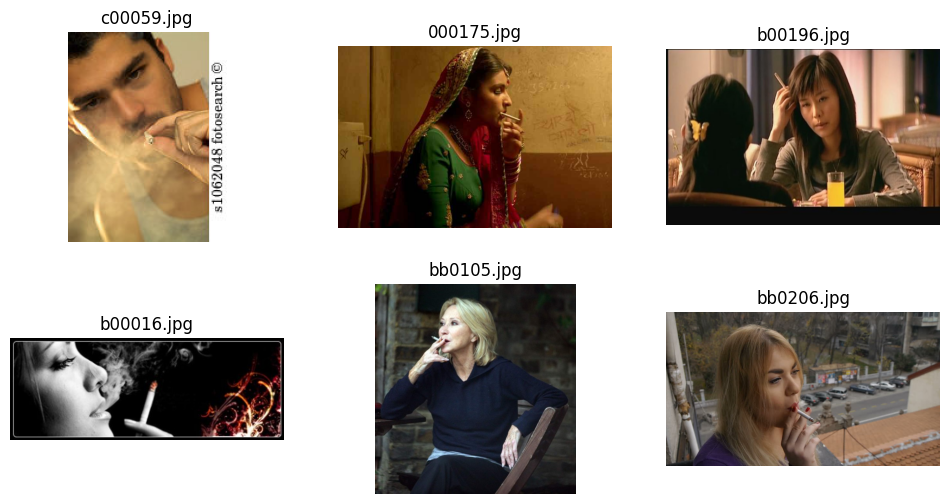

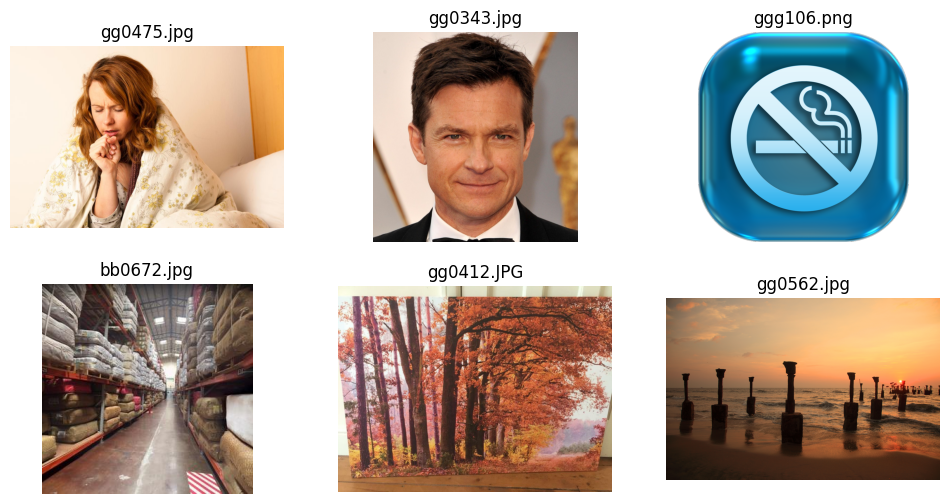

In [4]:
import matplotlib.image as mpimg
def show_random_samples(classname, n=6):
    folder = os.path.join(DATA_DIR, classname)
    imgs = [os.path.join(folder,f) for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png'))]
    if len(imgs)==0:
        print("No images in", classname); return
    samples = random.sample(imgs, min(n, len(imgs)))
    plt.figure(figsize=(12,6))
    for i,p in enumerate(samples):
        ax = plt.subplot(2,3,i+1)
        img = mpimg.imread(p)
        ax.imshow(img); ax.axis('off'); ax.set_title(os.path.basename(p))
    plt.show()

show_random_samples('cigarette_smoking', 6)
show_random_samples('not_smoking', 6)


In [4]:
train_ds = image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Class names:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# quick batch check
for imgs, labels in train_ds.take(1):
    print("batch shape:", imgs.shape, "labels shape:", labels.shape)


Found 3275 files belonging to 2 classes.
Using 2620 files for training.
Found 3275 files belonging to 2 classes.
Using 655 files for validation.
Class names: ['cigarette_smoking', 'not_smoking']
batch shape: (16, 224, 224, 3) labels shape: (16, 1)


In [2]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
], name="data_augmentation")

def build_model():
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    base = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE+(3,), include_top=False, weights='imagenet')
    base.trainable = False
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model, base

model, base_model = build_model()
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                      

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

ckpt = ModelCheckpoint("cig_model_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=False, verbose=1)


In [8]:
#(train initial)
EPOCHS = 6
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[ckpt, reduce_lr])


Epoch 1/6
164/164 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.7355
Epoch 1: val_accuracy improved from -inf to 0.78931, saving model to cig_model_best.h5
164/164 [==============================] - 97s 552ms/step - loss: 0.5427 - accuracy: 0.7355 - val_loss: 0.4579 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 2/6
164/164 [==============================] - ETA: 0s - loss: 0.4435 - accuracy: 0.8000
Epoch 2: val_accuracy improved from 0.78931 to 0.82748, saving model to cig_model_best.h5
164/164 [==============================] - 106s 643ms/step - loss: 0.4435 - accuracy: 0.8000 - val_loss: 0.4090 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 3/6
164/164 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8233
Epoch 3: val_accuracy did not improve from 0.82748
164/164 [==============================] - 110s 661ms/step - loss: 0.4134 - accuracy: 0.8233 - val_loss: 0.4108 - val_accuracy: 0.8153 - lr: 0.0010
Epoch 4/6
164/164 [=========================

In [9]:
#(fine-tune)
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])

FT_EPOCHS = 10
history_f = model.fit(train_ds, validation_data=val_ds, epochs=FT_EPOCHS, callbacks=[ckpt, reduce_lr, es])


Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 0.3727 - accuracy: 0.8454
Epoch 1: val_accuracy improved from 0.83969 to 0.84580, saving model to cig_model_best.h5
164/164 [==============================] - 119s 684ms/step - loss: 0.3727 - accuracy: 0.8454 - val_loss: 0.3721 - val_accuracy: 0.8458 - lr: 1.0000e-05
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.8485
Epoch 2: val_accuracy did not improve from 0.84580
164/164 [==============================] - 135s 817ms/step - loss: 0.3507 - accuracy: 0.8485 - val_loss: 0.3796 - val_accuracy: 0.8382 - lr: 1.0000e-05
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.8706
Epoch 3: val_accuracy improved from 0.84580 to 0.84733, saving model to cig_model_best.h5
164/164 [==============================] - 138s 833ms/step - loss: 0.3115 - accuracy: 0.8706 - val_loss: 0.3662 - val_accuracy: 0.8473 - lr: 1.0000e-05
Epoch 4/10
164/164 [=====

In [5]:
best = keras.models.load_model("cig_model_best.h5")
print("Loaded best model:", best)

from tensorflow.keras.preprocessing import image

def simple_predict(path):
    img = image.load_img(path, target_size=IMG_SIZE)
    arr = image.img_to_array(img); arr = np.expand_dims(arr,0)
    p_not = float(best.predict(arr)[0][0]); p_cig = 1-p_not
    print("Prob(cigarette_smoking) =", round(p_cig,3))
    print("Prob(not_smoking)       =", round(p_not,3))
    label = "cigarette_smoking" if p_cig>=0.5 else "not_smoking"
    plt.imshow(image.load_img(path)); plt.title(label); plt.axis("off"); plt.show()
    return p_cig, p_not


Loaded best model: <keras.engine.functional.Functional object at 0x0000023EFE389040>


In [11]:
!pip install scikit-learn


You should consider upgrading via the 'c:\users\gamik\mlproj\scripts\python.exe -m pip install --upgrade pip' command.


1/1 [==============================] - 2s 2s/step
Prob(cigarette_smoking) = 0.87
Prob(not_smoking)       = 0.13


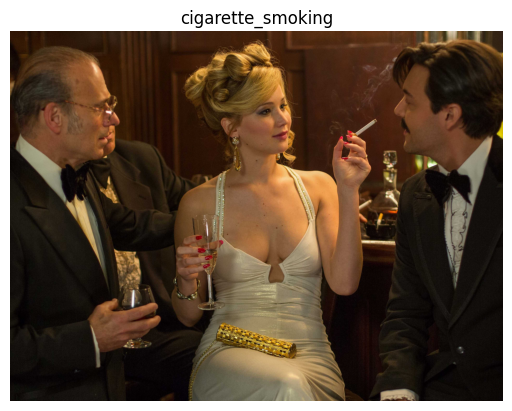

1/1 [==============================] - 0s 68ms/step
Prob(cigarette_smoking) = 0.923
Prob(not_smoking)       = 0.077


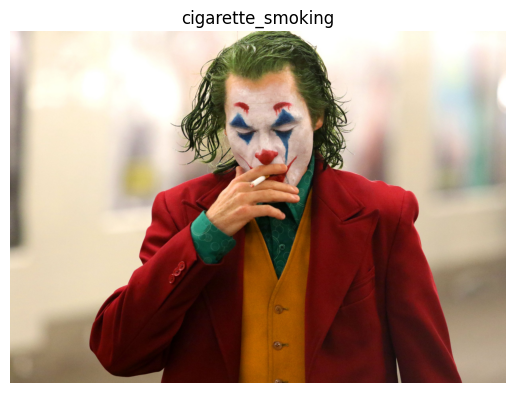

1/1 [==============================] - 0s 57ms/step
Prob(cigarette_smoking) = 0.156
Prob(not_smoking)       = 0.844


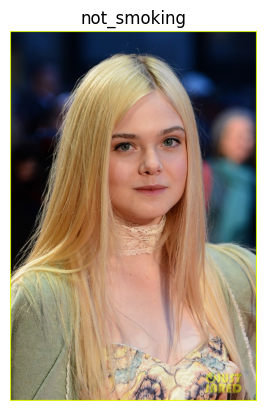

(0.15563136339187622, 0.8443686366081238)

In [6]:
# show model final output 
simple_predict(r"D:\Downlods\archive\data\dataset\cigarette_smoking\000302.jpg")
simple_predict(r"D:\Downlods\archive\data\dataset\cigarette_smoking\000571.jpg")
simple_predict(r"D:\Downlods\archive\data\dataset\not_smoking\gg0261.jpg")


In [28]:
#save model
try:
    best   # check if exists
    model_to_save = best
except:
    model_to_save = model

model_to_save.save("cigarette_model_final.h5")
print("Saved as cigarette_model_final.h5")


Saved as cigarette_model_final.h5


In [3]:
# CELL 0: install required packages in THIS environment (run once)
import sys, subprocess

def pip_install(packages):
    cmd = [sys.executable, "-m", "pip", "install", "--upgrade"] + packages
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)

try:
    import pandas, sklearn
    print("pandas and sklearn already installed")
except Exception as e:
    print("Installing pandas, scikit-learn")
    pip_install(["pandas", "scikit-learn"])


pandas and sklearn already installed


In [4]:
import os, sys
print("Python exe:", sys.executable)
print("Current dir:", os.getcwd())
print("Files here:", os.listdir("."))

MODEL_PATH = "best_cigarette_model.h5"   
TEST_DIR = "test"                       

# check model exists
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

from tensorflow.keras.models import load_model
print("Loading model:", MODEL_PATH)
model = load_model(MODEL_PATH, compile=False)
print("Model loaded.")


Python exe: c:\users\gamik\mlproj\scripts\python.exe
Current dir: D:\Downlods\archive\data
Files here: ['.ipynb_checkpoints', 'batch_predictions.csv', 'best_cigarette_model.h5', 'cigarette_model_final.h5', 'cigarette_smoking_detection_model.h5', 'cigarette_smoking_detection_model_best.h5', 'cig_model_best.h5', 'data', 'dataset', 'python.ipynb', 'python3.ipynb', 'READ.ME', 'test', 'Untitled.ipynb', 'Untitled1.ipynb']
Loading model: best_cigarette_model.h5
Model loaded.


In [6]:
!pip install tqdm


You should consider upgrading via the 'c:\users\gamik\mlproj\scripts\python.exe -m pip install --upgrade pip' command.


In [7]:
# CELL 2: batch predict and save CSV
import os, glob, pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
from tqdm import tqdm

TEST_DIR = TEST_DIR  # from previous cell
rows = []

# find all image files recursively under test/*/*
patterns = ("*.jpg","*.jpeg","*.png","*.bmp")
files = []
for root, dirs, filenames in os.walk(TEST_DIR):
    for fn in filenames:
        if fn.lower().endswith((".jpg",".jpeg",".png",".bmp")):
            files.append(os.path.join(root, fn))
files = sorted(files)
print("Found images:", len(files))
if len(files)==0:
    raise SystemExit("No images found in TEST_DIR. Check TEST_DIR path and structure.")

IMG_SZ = (224,224)
for fp in tqdm(files):
    try:
        img = image.load_img(fp, target_size=IMG_SZ)
        arr = image.img_to_array(img)
        arr = np.expand_dims(arr,0)
        p_not = float(model.predict(arr)[0][0])   # model outputs prob(not_smoking) as used earlier
        p_cig = 1 - p_not
        pred = "cigarette_smoking" if p_cig >= 0.5 else "not_smoking"
        true_label = os.path.basename(os.path.dirname(fp))  # parent folder name
        rows.append({
            "file_path": fp,
            "file_name": os.path.basename(fp),
            "true_label": true_label,
            "prob_cig": p_cig,
            "prob_not": p_not,
            "pred": pred
        })
    except Exception as e:
        rows.append({
            "file_path": fp,
            "file_name": os.path.basename(fp),
            "true_label": os.path.basename(os.path.dirname(fp)),
            "prob_cig": None,
            "prob_not": None,
            "pred": "ERROR: " + str(e)
        })

df = pd.DataFrame(rows)
out_csv = "predictions.csv"
df.to_csv(out_csv, index=False)
print("Saved predictions to", out_csv)
df.head(10)


Found images: 95


  0%|                                                                                           | 0/95 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  1%|▊                                                                                  | 1/95 [00:02<04:33,  2.90s/it]

1/1 [==============================] - 0s 105ms/step


  2%|█▋                                                                                 | 2/95 [00:03<02:05,  1.35s/it]

1/1 [==============================] - 0s 96ms/step


  3%|██▌                                                                                | 3/95 [00:03<01:16,  1.21it/s]

1/1 [==============================] - 0s 99ms/step


  4%|███▍                                                                               | 4/95 [00:03<00:52,  1.72it/s]

1/1 [==============================] - 0s 94ms/step


  5%|████▎                                                                              | 5/95 [00:03<00:39,  2.26it/s]

1/1 [==============================] - 0s 96ms/step


  6%|█████▏                                                                             | 6/95 [00:03<00:32,  2.77it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██████                                                                             | 7/95 [00:04<00:27,  3.25it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██████▉                                                                            | 8/95 [00:04<00:23,  3.65it/s]

1/1 [==============================] - 0s 95ms/step


  9%|███████▊                                                                           | 9/95 [00:04<00:21,  3.99it/s]

1/1 [==============================] - 0s 99ms/step


 11%|████████▋                                                                         | 10/95 [00:04<00:20,  4.23it/s]

1/1 [==============================] - 0s 101ms/step


 12%|█████████▍                                                                        | 11/95 [00:04<00:19,  4.40it/s]

1/1 [==============================] - 0s 109ms/step


 13%|██████████▎                                                                       | 12/95 [00:05<00:18,  4.47it/s]

1/1 [==============================] - 0s 120ms/step


 14%|███████████▏                                                                      | 13/95 [00:05<00:20,  4.07it/s]

1/1 [==============================] - 0s 104ms/step


 15%|████████████                                                                      | 14/95 [00:05<00:19,  4.06it/s]

1/1 [==============================] - 0s 127ms/step


 16%|████████████▉                                                                     | 15/95 [00:06<00:21,  3.73it/s]

1/1 [==============================] - 0s 136ms/step


 17%|█████████████▊                                                                    | 16/95 [00:06<00:21,  3.63it/s]

1/1 [==============================] - 0s 102ms/step


 18%|██████████████▋                                                                   | 17/95 [00:06<00:21,  3.66it/s]

1/1 [==============================] - 0s 100ms/step


 19%|███████████████▌                                                                  | 18/95 [00:06<00:21,  3.66it/s]

1/1 [==============================] - 0s 107ms/step


 20%|████████████████▍                                                                 | 19/95 [00:07<00:19,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 21%|█████████████████▎                                                                | 20/95 [00:07<00:18,  4.00it/s]

1/1 [==============================] - 0s 123ms/step


 22%|██████████████████▏                                                               | 21/95 [00:07<00:19,  3.89it/s]

1/1 [==============================] - 0s 131ms/step


 23%|██████████████████▉                                                               | 22/95 [00:07<00:19,  3.83it/s]

1/1 [==============================] - 0s 104ms/step


 24%|███████████████████▊                                                              | 23/95 [00:08<00:18,  3.91it/s]

1/1 [==============================] - 0s 100ms/step


 25%|████████████████████▋                                                             | 24/95 [00:08<00:17,  4.02it/s]

1/1 [==============================] - 0s 101ms/step


 26%|█████████████████████▌                                                            | 25/95 [00:08<00:16,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


 27%|██████████████████████▍                                                           | 26/95 [00:08<00:15,  4.39it/s]

1/1 [==============================] - 0s 104ms/step


 28%|███████████████████████▎                                                          | 27/95 [00:08<00:14,  4.60it/s]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████████▏                                                         | 28/95 [00:09<00:14,  4.77it/s]

1/1 [==============================] - 0s 95ms/step


 31%|█████████████████████████                                                         | 29/95 [00:09<00:13,  4.89it/s]

1/1 [==============================] - 0s 112ms/step


 32%|█████████████████████████▉                                                        | 30/95 [00:09<00:13,  4.92it/s]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████▊                                                       | 31/95 [00:09<00:12,  5.02it/s]

1/1 [==============================] - 0s 87ms/step


 34%|███████████████████████████▌                                                      | 32/95 [00:09<00:12,  4.99it/s]

1/1 [==============================] - 0s 93ms/step


 35%|████████████████████████████▍                                                     | 33/95 [00:10<00:12,  4.99it/s]

1/1 [==============================] - 0s 112ms/step


 36%|█████████████████████████████▎                                                    | 34/95 [00:10<00:12,  4.94it/s]

1/1 [==============================] - 0s 94ms/step


 37%|██████████████████████████████▏                                                   | 35/95 [00:10<00:12,  4.94it/s]

1/1 [==============================] - 0s 89ms/step


 38%|███████████████████████████████                                                   | 36/95 [00:10<00:11,  5.00it/s]

1/1 [==============================] - 0s 93ms/step


 39%|███████████████████████████████▉                                                  | 37/95 [00:10<00:11,  5.04it/s]

1/1 [==============================] - 0s 101ms/step


 40%|████████████████████████████████▊                                                 | 38/95 [00:11<00:11,  5.10it/s]

1/1 [==============================] - 0s 97ms/step


 41%|█████████████████████████████████▋                                                | 39/95 [00:11<00:10,  5.10it/s]

1/1 [==============================] - 0s 92ms/step


 42%|██████████████████████████████████▌                                               | 40/95 [00:11<00:10,  5.13it/s]

1/1 [==============================] - 0s 100ms/step


 43%|███████████████████████████████████▍                                              | 41/95 [00:11<00:10,  5.17it/s]

1/1 [==============================] - 0s 104ms/step


 44%|████████████████████████████████████▎                                             | 42/95 [00:11<00:10,  5.00it/s]

1/1 [==============================] - 0s 97ms/step


 45%|█████████████████████████████████████                                             | 43/95 [00:12<00:10,  4.84it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████████████████████████▉                                            | 44/95 [00:12<00:11,  4.53it/s]

1/1 [==============================] - 0s 145ms/step


 47%|██████████████████████████████████████▊                                           | 45/95 [00:12<00:12,  3.99it/s]

1/1 [==============================] - 0s 120ms/step


 48%|███████████████████████████████████████▋                                          | 46/95 [00:13<00:13,  3.56it/s]

1/1 [==============================] - 0s 106ms/step


 49%|████████████████████████████████████████▌                                         | 47/95 [00:13<00:12,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████████████████████████████████████████▍                                        | 48/95 [00:13<00:12,  3.68it/s]

1/1 [==============================] - 0s 112ms/step


 52%|██████████████████████████████████████████▎                                       | 49/95 [00:15<00:32,  1.41it/s]

1/1 [==============================] - 0s 115ms/step


 53%|███████████████████████████████████████████▏                                      | 50/95 [00:15<00:26,  1.69it/s]

1/1 [==============================] - 0s 95ms/step


 54%|████████████████████████████████████████████                                      | 51/95 [00:15<00:21,  2.08it/s]

1/1 [==============================] - 0s 98ms/step


 55%|████████████████████████████████████████████▉                                     | 52/95 [00:16<00:17,  2.49it/s]

1/1 [==============================] - 0s 99ms/step


 56%|█████████████████████████████████████████████▋                                    | 53/95 [00:16<00:14,  2.89it/s]

1/1 [==============================] - 0s 100ms/step


 57%|██████████████████████████████████████████████▌                                   | 54/95 [00:16<00:12,  3.27it/s]

1/1 [==============================] - 0s 134ms/step


 58%|███████████████████████████████████████████████▍                                  | 55/95 [00:16<00:13,  3.06it/s]

1/1 [==============================] - 0s 104ms/step


 59%|████████████████████████████████████████████████▎                                 | 56/95 [00:17<00:12,  3.05it/s]

1/1 [==============================] - 0s 107ms/step


 60%|█████████████████████████████████████████████████▏                                | 57/95 [00:17<00:11,  3.33it/s]

1/1 [==============================] - 0s 109ms/step


 61%|██████████████████████████████████████████████████                                | 58/95 [00:17<00:11,  3.11it/s]

1/1 [==============================] - 0s 105ms/step


 62%|██████████████████████████████████████████████████▉                               | 59/95 [00:18<00:10,  3.37it/s]

1/1 [==============================] - 0s 137ms/step


 63%|███████████████████████████████████████████████████▊                              | 60/95 [00:18<00:11,  3.00it/s]

1/1 [==============================] - 0s 195ms/step


 64%|████████████████████████████████████████████████████▋                             | 61/95 [00:18<00:11,  2.86it/s]

1/1 [==============================] - 0s 137ms/step


 65%|█████████████████████████████████████████████████████▌                            | 62/95 [00:19<00:11,  2.77it/s]

1/1 [==============================] - 0s 200ms/step


 66%|██████████████████████████████████████████████████████▍                           | 63/95 [00:19<00:12,  2.64it/s]

1/1 [==============================] - 0s 183ms/step


 67%|███████████████████████████████████████████████████████▏                          | 64/95 [00:20<00:12,  2.56it/s]

1/1 [==============================] - 0s 202ms/step


 68%|████████████████████████████████████████████████████████                          | 65/95 [00:20<00:12,  2.38it/s]

1/1 [==============================] - 0s 184ms/step


 69%|████████████████████████████████████████████████████████▉                         | 66/95 [00:20<00:11,  2.57it/s]

1/1 [==============================] - 0s 149ms/step


 71%|█████████████████████████████████████████████████████████▊                        | 67/95 [00:21<00:11,  2.53it/s]

1/1 [==============================] - 0s 103ms/step


 72%|██████████████████████████████████████████████████████████▋                       | 68/95 [00:21<00:09,  2.92it/s]

1/1 [==============================] - 0s 99ms/step


 73%|███████████████████████████████████████████████████████████▌                      | 69/95 [00:21<00:08,  3.24it/s]

1/1 [==============================] - 0s 124ms/step


 74%|████████████████████████████████████████████████████████████▍                     | 70/95 [00:22<00:08,  3.01it/s]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████████████████████████████████████▎                    | 71/95 [00:22<00:07,  3.10it/s]

1/1 [==============================] - 0s 105ms/step


 76%|██████████████████████████████████████████████████████████████▏                   | 72/95 [00:22<00:06,  3.46it/s]

1/1 [==============================] - 0s 102ms/step


 77%|███████████████████████████████████████████████████████████████                   | 73/95 [00:22<00:06,  3.55it/s]

1/1 [==============================] - 0s 104ms/step


 78%|███████████████████████████████████████████████████████████████▊                  | 74/95 [00:23<00:06,  3.10it/s]

1/1 [==============================] - 0s 93ms/step


 79%|████████████████████████████████████████████████████████████████▋                 | 75/95 [00:23<00:05,  3.39it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 76/95 [00:23<00:05,  3.74it/s]

1/1 [==============================] - 0s 105ms/step


 81%|██████████████████████████████████████████████████████████████████▍               | 77/95 [00:23<00:04,  4.04it/s]

1/1 [==============================] - 0s 102ms/step


 82%|███████████████████████████████████████████████████████████████████▎              | 78/95 [00:24<00:04,  4.08it/s]

1/1 [==============================] - 0s 84ms/step


 83%|████████████████████████████████████████████████████████████████████▏             | 79/95 [00:24<00:03,  4.03it/s]

1/1 [==============================] - 0s 98ms/step


 84%|█████████████████████████████████████████████████████████████████████             | 80/95 [00:24<00:03,  4.28it/s]

1/1 [==============================] - 0s 103ms/step


 85%|█████████████████████████████████████████████████████████████████████▉            | 81/95 [00:24<00:03,  4.39it/s]

1/1 [==============================] - 0s 106ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 82/95 [00:25<00:03,  3.59it/s]

1/1 [==============================] - 0s 106ms/step


 87%|███████████████████████████████████████████████████████████████████████▋          | 83/95 [00:25<00:03,  3.87it/s]

1/1 [==============================] - 0s 144ms/step


 88%|████████████████████████████████████████████████████████████████████████▌         | 84/95 [00:25<00:03,  3.53it/s]

1/1 [==============================] - 0s 101ms/step


 89%|█████████████████████████████████████████████████████████████████████████▎        | 85/95 [00:26<00:02,  3.85it/s]

1/1 [==============================] - 0s 99ms/step


 91%|██████████████████████████████████████████████████████████████████████████▏       | 86/95 [00:26<00:02,  4.11it/s]

1/1 [==============================] - 0s 98ms/step


 92%|███████████████████████████████████████████████████████████████████████████       | 87/95 [00:26<00:01,  4.33it/s]

1/1 [==============================] - 0s 85ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 88/95 [00:26<00:01,  4.55it/s]

1/1 [==============================] - 0s 103ms/step


 94%|████████████████████████████████████████████████████████████████████████████▊     | 89/95 [00:26<00:01,  4.19it/s]

1/1 [==============================] - 0s 100ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 90/95 [00:27<00:01,  4.25it/s]

1/1 [==============================] - 0s 99ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 91/95 [00:27<00:00,  4.37it/s]

1/1 [==============================] - 0s 187ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▍  | 92/95 [00:27<00:00,  3.33it/s]

1/1 [==============================] - 0s 164ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 93/95 [00:28<00:00,  3.00it/s]

1/1 [==============================] - 0s 127ms/step


 99%|█████████████████████████████████████████████████████████████████████████████████▏| 94/95 [00:28<00:00,  2.30it/s]

1/1 [==============================] - 0s 103ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:29<00:00,  3.25it/s]

Saved predictions to predictions.csv


,file_path,file_name,true_label,prob_cig,prob_not,pred
0,test\cigarette_smoking\000062.jpg,000062.jpg,cigarette_smoking,0.872870,0.127130,cigarette_smoking
1,test\cigarette_smoking\000063.jpeg,000063.jpeg,cigarette_smoking,0.716956,0.283044,cigarette_smoking
2,test\cigarette_smoking\000064.jpg,000064.jpg,cigarette_smoking,0.988051,0.011949,cigarette_smoking
3,test\cigarette_smoking\000065.jpg,000065.jpg,cigarette_smoking,0.993426,0.006574,cigarette_smoking
4,test\cigarette_smoking\000066.jpg,000066.jpg,cigarette_smoking,0.918985,0.081015,cigarette_smoking
5,test\cigarette_smoking\000067.jpeg,000067.jpeg,cigarette_smoking,0.909826,0.090174,cigarette_smoking
6,test\cigarette_smoking\000067.jpg,000067.jpg,cigarette_smoking,0.909464,0.090536,cigarette_smoking
7,test\cigarette_smoking\000068.jpg,000068.jpg,cigarette_smoking,0.756999,0.243001,cigarette_smoking
8,test\cigarette_smoking\000069.jpeg,000069.jpeg,cigarette_smoking,0.969889,0.030111,cigarette_smoking
9,test\cigarette_smoking\000069.jpg,000069.jpg,cigarette_smoking,0.994438,0.005562,cigarette_smoking


In [9]:
!pip install seaborn

You should consider upgrading via the 'c:\users\gamik\mlproj\scripts\python.exe -m pip install --upgrade pip' command.


Labels: ['cigarette_smoking', 'not_smoking']
Accuracy: 0.8736842105263158
Saved classification_report.txt


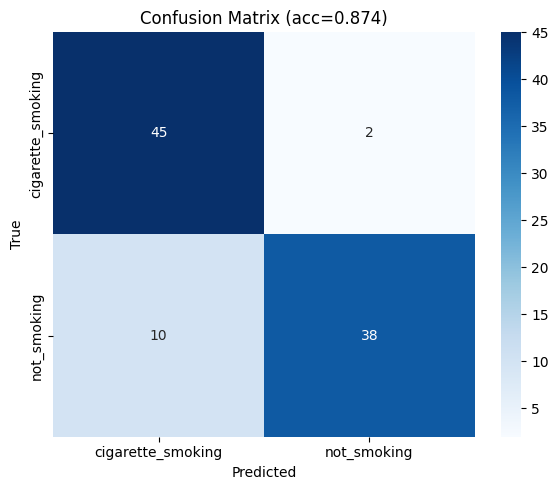

Saved confusion_matrix.png

Classification report:

                   precision    recall  f1-score   support

cigarette_smoking     0.8182    0.9574    0.8824        47
      not_smoking     0.9500    0.7917    0.8636        48

         accuracy                         0.8737        95
        macro avg     0.8841    0.8746    0.8730        95
     weighted avg     0.8848    0.8737    0.8729        95



In [10]:
# CELL 3: metrics + confusion matrix
import pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("predictions.csv")
# drop rows with errors
df_valid = df[df['pred'].notnull() & ~df['pred'].str.startswith("ERROR")].copy()
y_true = df_valid['true_label'].values
y_pred = df_valid['pred'].values

labels = sorted(list(set(y_true)))  # ensures order like ['cigarette_smoking','not_smoking'] maybe alphabetic
print("Labels:", labels)

# numeric mapping for matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# save classification report
crep = classification_report(y_true, y_pred, target_names=labels, digits=4)
with open("classification_report.txt","w", encoding="utf-8") as f:
    f.write("Accuracy: %.4f\n\n" % acc)
    f.write(crep)
print("Saved classification_report.txt")

# plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (acc={acc:.3f})")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()
print("Saved confusion_matrix.png")
print("\nClassification report:\n")
print(crep)


Total misclassified: 12


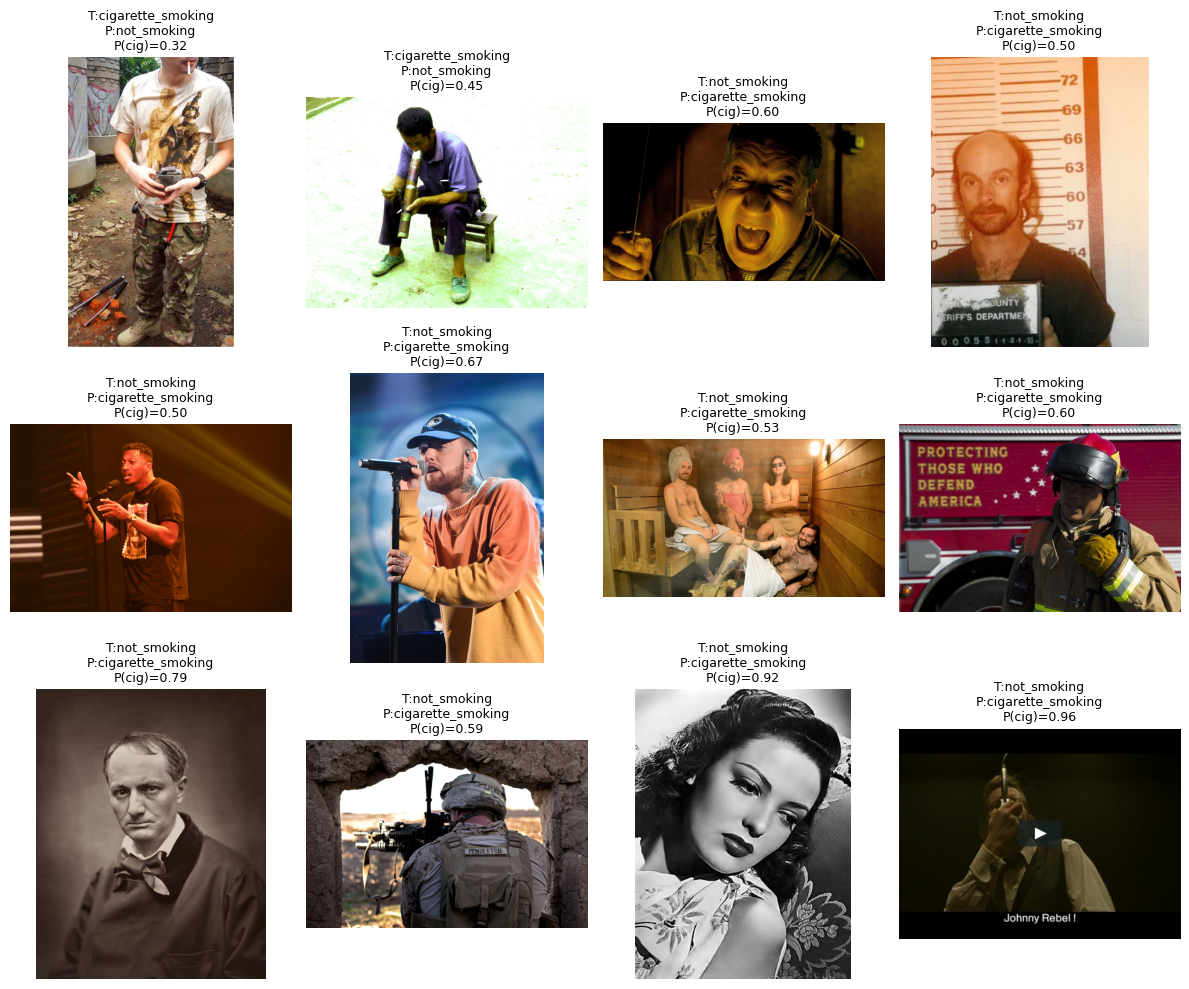

Misclassified images copied to folder: misclassified


In [11]:
#misclassified images (first 12)
import os, shutil
from PIL import Image
import matplotlib.pyplot as plt

df = pd.read_csv("predictions.csv")
df_valid = df[df['pred'].notnull() & ~df['pred'].str.startswith("ERROR")].copy()
wrong = df_valid[df_valid['true_label'] != df_valid['pred']].reset_index(drop=True)
print("Total misclassified:", len(wrong))

OUT_DIR = "misclassified"
os.makedirs(OUT_DIR, exist_ok=True)

n = min(12, len(wrong))
plt.figure(figsize=(12, 3*n//4 + 1))
for i in range(n):
    row = wrong.loc[i]
    src = row['file_path']
    dst = os.path.join(OUT_DIR, f"{i}_{row['true_label']}_pred-{row['pred']}_{row['file_name']}")
    try:
        # copy original image file
        shutil.copy(src, dst)
        img = Image.open(dst).convert("RGB")
        plt.subplot((n+3)//4, 4, i+1)
        plt.imshow(img)
        title = f"T:{row['true_label']}\nP:{row['pred']}\nP(cig)={row['prob_cig']:.2f}"
        plt.title(title, fontsize=9)
        plt.axis("off")
    except Exception as e:
        print("Error copying/displaying", src, e)

plt.tight_layout()
plt.show()
print("Misclassified images copied to folder:", OUT_DIR)


### 3.2 Dataset Description
The study uses a custom cigarette smoking detection dataset collected from publicly available sources. The dataset contains **3275 images** divided into two categories:

- **cigarette_smoking** → **1996 images**  
- **not_smoking** → **1279 images**  

All images were resized to **224 × 224 pixels** in RGB format to match MobileNetV2 input requirements. Basic preprocessing (scaling/normalization) was applied. Noisy or very low-quality images were removed to reduce ambiguity.

The dataset shows a moderate class imbalance (smoking > not_smoking). To handle this, data augmentation and careful fine-tuning were applied during training to improve generalization across both classes.

Property,Value
Total Images,3275
Classes,"2 (cigarette_smoking, not_smoking)"
Largest Class,cigarette_smoking (1996)
Smallest Class,not_smoking (1279)
Input Size,224 × 224 (RGB)


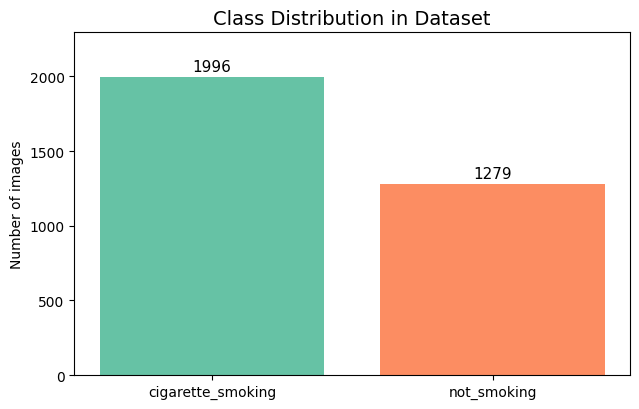

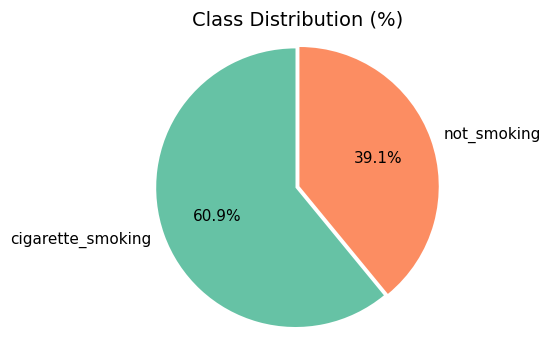

**Charts saved:** `D:\Downlods\archive\data\dataset_bar.png` and `D:\Downlods\archive\data\dataset_pie.png`

**Summary:** The dataset contains 3275 images (1996 smoking, 1279 not-smoking). Images are standardized to 224×224 RGB and preprocessed for training.

In [12]:
# ======= Cell: Dataset Description + Charts (copy-paste into Jupyter) =======
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML
import numpy as np
import os

# --- 1) Dataset counts (change if tumhare counts alag ho to yaha update kar dena) ---
count_smoking = 1996
count_not_smoking = 1279
total_images = count_smoking + count_not_smoking

# --- 2) Text description (formatted) ---
title_md = "### 3.2 Dataset Description\n"
paragraph_md = (
    "The study uses a custom cigarette smoking detection dataset collected from publicly "
    "available sources. The dataset contains **{tot} images** divided into two categories:\n\n"
    "- **cigarette_smoking** → **{sm} images**  \n"
    "- **not_smoking** → **{ns} images**  \n\n"
    "All images were resized to **224 × 224 pixels** in RGB format to match MobileNetV2 "
    "input requirements. Basic preprocessing (scaling/normalization) was applied. Noisy or "
    "very low-quality images were removed to reduce ambiguity.\n\n"
    "The dataset shows a moderate class imbalance (smoking > not_smoking). To handle this, "
    "data augmentation and careful fine-tuning were applied during training to improve "
    "generalization across both classes."
).format(tot=total_images, sm=count_smoking, ns=count_not_smoking)

# Display markdown (nice formatted text)
display(Markdown(title_md + paragraph_md))

# --- 3) Simple stats table as HTML (neat display) ---
table_html = f"""
<table style="width:50%; border-collapse: collapse;">
  <tr><th style="text-align:left; padding:6px; border-bottom:1px solid #ddd;">Property</th>
      <th style="text-align:left; padding:6px; border-bottom:1px solid #ddd;">Value</th></tr>
  <tr><td style="padding:6px; border-bottom:1px solid #eee;">Total Images</td><td style="padding:6px; border-bottom:1px solid #eee;">{total_images}</td></tr>
  <tr><td style="padding:6px; border-bottom:1px solid #eee;">Classes</td><td style="padding:6px; border-bottom:1px solid #eee;">2 (cigarette_smoking, not_smoking)</td></tr>
  <tr><td style="padding:6px; border-bottom:1px solid #eee;">Largest Class</td><td style="padding:6px; border-bottom:1px solid #eee;">cigarette_smoking ({count_smoking})</td></tr>
  <tr><td style="padding:6px; border-bottom:1px solid #eee;">Smallest Class</td><td style="padding:6px; border-bottom:1px solid #eee;">not_smoking ({count_not_smoking})</td></tr>
  <tr><td style="padding:6px;">Input Size</td><td style="padding:6px;">224 × 224 (RGB)</td></tr>
</table>
"""
display(HTML(table_html))

# --- 4) Create charts (Bar chart + Pie chart) ---
labels = ['cigarette_smoking', 'not_smoking']
counts = [count_smoking, count_not_smoking]
colors = ['#66c2a5', '#fc8d62']  # pleasant colors

# Bar chart
plt.figure(figsize=(6.5,4.2))
bars = plt.bar(labels, counts, color=colors)
plt.title('Class Distribution in Dataset', fontsize=14)
plt.ylabel('Number of images')
plt.ylim(0, max(counts)*1.15)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + max(counts)*0.02, f'{int(h)}', ha='center', fontsize=11)
plt.tight_layout()
bar_path = "dataset_bar.png"
plt.savefig(bar_path, dpi=150)
plt.show()

# Pie chart (percentage)
plt.figure(figsize=(5,4))
pct = [c / total_images * 100 for c in counts]
explode = (0.03, 0)  # slightly explode the first slice
wedges, texts, autotexts = plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90,
                                   explode=explode, colors=colors, textprops={'fontsize':11})
plt.axis('equal')
plt.title('Class Distribution (%)', fontsize=14)
pie_path = "dataset_pie.png"
plt.savefig(pie_path, dpi=150)
plt.show()

# --- 5) Save images and report saved paths ---
cwd = os.getcwd()
display(Markdown(f"**Charts saved:** `{os.path.join(cwd, bar_path)}` and `{os.path.join(cwd, pie_path)}`"))

# --- 6) Short summary line for report footer ---
summary = (
    f"**Summary:** The dataset contains {total_images} images ("
    f"{count_smoking} smoking, {count_not_smoking} not-smoking). "
    "Images are standardized to 224×224 RGB and preprocessed for training."
)
display(Markdown(summary))
# ========================================================================
